# Recommendation systems

## Theory and Background

https://docs.google.com/document/d/1TR4TqttP68DgXE08PpK_E8RVebDqN5PpLiFaeksfapo/edit?usp=sharing

## Imports

In [ ]:
import pandas as pd 
import gc
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel

#import nltk
import re
#from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords


### Loading the data

the Dataset is downloaded from https://grouplens.org/datasets/movielens/
under the section : recommended for education and development 
this is the latest dataset on the website, and the largest one for developemnt purposes to add a little bit of challenges to our case study

The data is very big, so they splitted it into multiple files: 
- Movies.csv: Each line of this file after the header row represents one movie, and has the following format:
    movieId,title,genres

- tags.csv: All tags are contained here. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

    userId,movieId,tag,timestamp

- Ratings.csv: each line of this file after the header row represents one rating of one movie by one user, and has the following format:
    userId,movieId,rating,timestamp


- genome data: 
  briefly, The tag genome is a data structure that contains tag relevance scores for movies.  The structure is a dense matrix: each movie in the genome has a value for *every* tag in the genome.

the tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews.

* `genome-scores.csv` contains movie-tag relevance data in the following format:
    movieId,tagId,relevance

* `genome-tags.csv`, provides the tag descriptions for the tag IDs in the genome file, in the following format:

    tagId,tag



In [ ]:
path = "D:/mina/AUC/Spring 2022 - 4th year 2nd semester/data science/project/ml-latest/"
ratingsDf = pd.read_csv(path + "ratings.csv")
moviesDf = pd.read_csv(path + 'movies.csv')
tagsDf = pd.read_csv(path + 'tags.csv')
genomeScoresDf = pd.read_csv(path + 'genome-scores.csv')
genomeTagsDf = pd.read_csv(path + 'genome-tags.csv')

In [ ]:
#exploring the null values if any
print("---- Null Values ----\n", ratingsDf.isnull().sum(), "\n")
print("---- Null Values ----\n", tagsDf.isnull().sum(), "\n")
print("---- Null Values ----\n", genomeScoresDf.isnull().sum(), "\n")
print("---- Null Values ----\n", genomeTagsDf.isnull().sum(), "\n")
print("---- Null Values ----\n", moviesDf.isnull().sum(), "\n")

---- Null Values ----
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 

---- Null Values ----
 userId        0
movieId       0
tag          16
timestamp     0
dtype: int64 

---- Null Values ----
 movieId      0
tagId        0
relevance    0
dtype: int64 

---- Null Values ----
 tagId    0
tag      0
dtype: int64 

---- Null Values ----
 movieId    0
title      0
genres     0
dtype: int64 



In [ ]:
#let's just drop the NA values
tagsDf.dropna(inplace=True)

In [ ]:
print(ratingsDf['rating'].describe())
ratingsDf.sample(5)

count    2.775344e+07
mean     3.530445e+00
std      1.066353e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


,userId,movieId,rating,timestamp
15142465,154715,2716,4.5,1145389437
14071083,144056,2881,4.0,1185744900
14201339,145357,8961,4.5,1114214512
24294945,248443,1784,5.0,1532621684
24733616,252831,1653,3.0,901634641


we can see that the minumum rating in the data is 0.5 and the max is 5. For each row we have a userId and a movieId with a rating and a timestamp

let's now check for duplicates if a user has rated the same movie twice 

In [ ]:
ratingsDf.duplicated(subset=['userId', 'movieId'], keep=False).sum()

0

In [ ]:
moviesDf.sample(5)

,movieId,title,genres
30239,130089,Crazy Beautiful You (2015),(no genres listed)
54157,184571,The Silent Child (2017),Drama
41499,156702,Joey (1997),Children
49993,175405,The Thirst for Gold (1993),Comedy
45713,166187,Faro (2013),Drama|Thriller


here we can notice 2 things, the title that has the year in the same string, and that all the genres are in one string separated by a pipe character. So let's process it and see what we end up with 

processing the years is going to be useful in a production app since some users like to filter movies from a specific year or sort them from oldest to newest 


In [ ]:
moviesDf[moviesDf.duplicated(keep=False)].sort_values('title').head(5)

,movieId,title,genres


In [ ]:
tagsDf.sample(5)

,userId,movieId,tag,timestamp
1049563,268469,79702,Edgar Wright,1523166832
544777,103013,524,great acting,1407829400
1024967,257051,99917,existentialism,1451662997
281233,73406,835,hostage,1527451960
1057479,268681,47606,BD-R,1360441609


the tags are here per user and movie with a timestamp. Each row has only 1 tag and it is a string 

the genome score is the result of a research paper by the grouplens group that extarcted a set of 1128 tags per movie and for each tag, it assigned a relevance rank to it.

In [ ]:
genomeScoresDf.sample(5)

,movieId,tagId,relevance
3715610,3680,1107,0.01350
3333430,3289,191,0.40225
13730396,127204,381,0.01975
4220777,4168,930,0.01200
674555,634,12,0.05600


In [ ]:
print(len(genomeScoresDf['tagId'].unique()))
print(len(genomeTagsDf['tagId'].unique()))
print(genomeScoresDf.shape)

1128
1128
(14862528, 3)


the genome tags is just each tagId from the genomescore with its corresponding text.


In [ ]:
genomeTagsDf.sample(5)

,tagId,tag
823,824,psychology
290,291,deadpan
67,68,anti-semitism
693,694,natural disaster
565,566,irreverent


## Data cleaning 
### processing the year

In [ ]:
def removeYear(row):
    if row['year'] == 0:
        return row['title']
    else:
        return row['title'][:-7]

#extract years from the title
moviesDf['year'] = moviesDf['title'].str.extract('(\(\d\d\d\d\))', expand=False)
moviesDf['year'].fillna('0000', inplace=True)
moviesDf['year'] = moviesDf['year'].str[1:-1].astype(int)

moviesDf['title'] = moviesDf.apply(lambda row: removeYear(row), axis=1)
moviesDf.sample(5)

,movieId,title,genres,year
20614,100246,Pretty Sweet,Documentary,2012
57156,191423,The Punk Voyage,Documentary,2017
14669,73086,"Fallen Sparrow, The",Film-Noir|Thriller,1943
31470,132967,Thursday Till Sunday,Drama,2012
31288,132561,Bad Boys,Documentary,2014


some movies specially old ones, had no genres listed to them. In this case, they will be marked with the string (no genres listed)

moreover, some movies didn't have the year in the title, so you will find them with a 0 in front of them 

In [ ]:
moviesDf[moviesDf['year'] == 0].head()

,movieId,title,genres,year
10023,32930,Category 6: Day of Destruction,Action|Drama,0
10613,40697,Babylon 5,Sci-Fi,0
15719,79607,"Millions Game, The (Das Millionenspiel)",Action|Drama|Sci-Fi|Thriller,0
17444,87442,"Bicycle, Spoon, Apple (Bicicleta, cullera, poma)",Documentary,0
22651,107434,Diplomatic Immunity (2009– ),Comedy,0


In [ ]:
moviesDf.sample(10)

,movieId,title,genres,year
18652,92243,"Flowers of War, The (Jin líng shí san chai)",Drama|War,2011
51526,178819,Beforel Orel: Trust,(no genres listed),2012
47209,169426,Indivisible,Drama,2016
31733,133571,Specters,Horror,1987
13802,68901,Chop Shop,Drama,2007
7571,7936,Shame (Skammen),Drama|War,1968
886,903,Vertigo,Drama|Mystery|Romance|Thriller,1958
49563,174433,The Black Connection,Action,1974
37474,147024,Prem Ratan Dhan Payo,Drama|Romance,2015
47226,169460,Malibu Shark Attack,Horror,2009


you will now find two code cells that are commented out because I figured out that I was doing something completely stupid that consumed a ton of memory. I created dummy one-hot column for each tag and that ended up increasing 21 column for each movie of the 58000. 

In [ ]:
'''
x = moviesDf.genres.str.split(r'|', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre');  
y = pd.get_dummies(x, prefix='g', columns=['genre']).groupby(level=0).sum()
del x
y.head()
'''

"\nx = moviesDf.genres.str.split(r'|', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre');  \ny = pd.get_dummies(x, prefix='g', columns=['genre']).groupby(level=0).sum()\ndel x\ny.head()\n"

In [ ]:
'''
y.drop(columns=['g_(no genres listed)'], inplace=True)
moviesDf = pd.concat([moviesDf, y], axis=1)
moviesDf.sample(5)
'''

"\ny.drop(columns=['g_(no genres listed)'], inplace=True)\nmoviesDf = pd.concat([moviesDf, y], axis=1)\nmoviesDf.sample(5)\n"

In [ ]:
ratingsDf.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


As you might have noticed, the timestamp is not very friendly. So, I will convert them to the usual datetime format we are used to 

In [ ]:
ratingsDf['date'] = pd.to_datetime(ratingsDf['timestamp'],unit='s')
ratingsDf.head()


,userId,movieId,rating,timestamp,date
0,1,307,3.5,1256677221,2009-10-27 21:00:21
1,1,481,3.5,1256677456,2009-10-27 21:04:16
2,1,1091,1.5,1256677471,2009-10-27 21:04:31
3,1,1257,4.5,1256677460,2009-10-27 21:04:20
4,1,1449,4.5,1256677264,2009-10-27 21:01:04


In [ ]:

tagsDf['date'] = pd.to_datetime(tagsDf['timestamp'],unit='s')
tagsDf.head()

,userId,movieId,tag,timestamp,date
0,14,110,epic,1443148538,2015-09-25 02:35:38
1,14,110,Medieval,1443148532,2015-09-25 02:35:32
2,14,260,sci-fi,1442169410,2015-09-13 18:36:50
3,14,260,space action,1442169421,2015-09-13 18:37:01
4,14,318,imdb top 250,1442615195,2015-09-18 22:26:35


In [ ]:
ratingsDf.drop(columns=['timestamp'], inplace=True)
tagsDf.drop(columns=['timestamp'], inplace=True)

In [ ]:
#to be honest, after I cleaned the data, I don't think I needed to do this
#so let's just drop the date column, too
ratingsDf.drop(columns=['date'], inplace=True)
tagsDf.drop(columns=['date'], inplace=True)

# Precision@K

now, Let's write a function that we will use in the future when we try to evaluate our system.


It's a very famous metric that is used in evaluating recommendation systems 

In [ ]:
#evaluate precision at k
def precision_at_k(y_true, y_score, k, pos_label=1):
    from sklearn.utils import column_or_1d
    from sklearn.utils.multiclass import type_of_target
    
    y_true_type = type_of_target(y_true)
    if not (y_true_type == "binary"):
        raise ValueError("y_true must be a binary column.")
    
    # Makes this compatible with various array types
    y_true_arr = column_or_1d(y_true)
    y_score_arr = column_or_1d(y_score)
    
    y_true_arr = y_true_arr == pos_label
    
    desc_sort_order = np.argsort(y_score_arr)[::-1]
    y_true_sorted = y_true_arr[desc_sort_order]
    y_score_sorted = y_score_arr[desc_sort_order]
    
    true_positives = y_true_sorted[:k].sum()
    
    return true_positives / k

# Popularity-based recommender

now let's start buidling the simplest recommendation engine that we can think of.
![image](https://decider.com/wp-content/uploads/2020/02/netflix-10-.jpg)


<h4> it is as simple as just checking what other people have watched the most and then recommending them as they are the top popular items in our dataset.

we now have a big problem. What if the most popular item in the dataset had a very low average rating and people REALLY hated it. Should we recommend it? 

it is a research question, some would argue that yes, recommending it is a good idea, and some would say no. I just implemented a very simple scoring policy that normalizes the views between 0 and 1. Then, multiply it by the average rating of each movie and sort by that new score.

you will notice that practically, most movies that were really popular, had really good rankings, except for a few movies that we don't really want to be in the top K recommendations we make 

In [ ]:
#to get trending movies, we cannot rely on the ratings date alone as you can see users rating are seconds apart from each other
#this is generally because GroupLens were surveing users on movies they had already watched so each rating is seconds from the next rating 
#instead, we can count the number of ratings (Most popular movies), then filter on movies with high rankings to get movies people liked 

TrendingDf = pd.DataFrame(ratingsDf.groupby(by='movieId')['rating'].mean())
TrendingDf.sample(10)

,rating
movieId,
169650,2.250000
7878,3.048077
102263,3.203704
138420,2.666667
149410,3.500000
192521,3.500000
175509,3.500000
97035,2.687500
192897,2.500000


now, the rating is the average rating per movie, which we should use in making new recommendations.


there is a new problem, which is that some movies were viewed by only very few people

In [ ]:
TrendingDf['views'] = ratingsDf.groupby('movieId')['rating'].count()
TrendingDf.sort_values(['views', 'rating'] , inplace=True, ascending = False)
top10Watched = TrendingDf.head(10)

I was just very curious to see which movies are the most watched in this dataset xD. This next part is completely unrelated to recommendation systems, this is me playing with the data. Feel free to skip

In [ ]:
#let's get movie name from its ID to see the movies with the highest scores in our recommender
def getMovieTitle(df, colName, row):
    id = int(row[colName])
    x = df[df[colName] == id] 
    return x['title'].values[0]


In [ ]:
top10Watched.reset_index(inplace=True)
for index, row in top10Watched.iterrows():
    print(getMovieTitle(moviesDf, 'movieId', row))


Shawshank Redemption, The
Forrest Gump
Pulp Fiction
Silence of the Lambs, The
Matrix, The
Star Wars: Episode IV - A New Hope
Jurassic Park
Schindler's List
Braveheart
Toy Story


since The shawshank redemption is on the top of the list❤️, then I

![image](https://memegenerator.net/img/instances/31018225.jpg)

C:\Program Files\Python310\lib\site-packages\seaborn-0.11.0-py3.10.egg\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

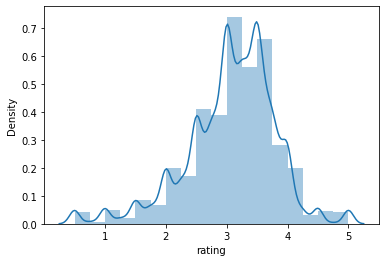

In [ ]:
sns.distplot(TrendingDf['rating'], bins=18)

<h3> We can see that most movies have an average ranking of 3 to 3.5. very few movies have very low ranking and very few movies have very high ranking.


<AxesSubplot:>

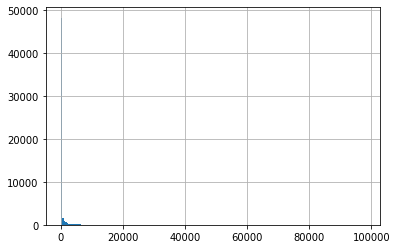

In [ ]:
TrendingDf['views'].hist(bins=200)

<h4> Most movies have very very low views. This is generally true for most content generated on the internet. Very few videos or movies or articles succeed.  This doesn't mean we should not recommed movies from the left end of the tail to the users, but it just makes our job hard in picking which one to recommend 

<AxesSubplot:xlabel='views', ylabel='movieId'>

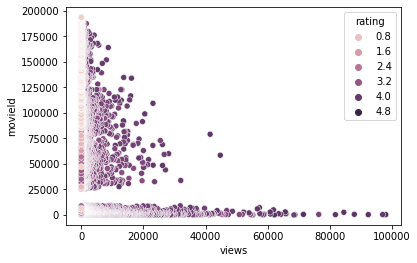

In [ ]:
sns.scatterplot(x='views', y='movieId', data=TrendingDf, hue='rating')

In [ ]:
#based on the definition of a our most-popular movie recommendation engine 
#we are going to recommend movies based on their current views

#there is a problem here which is that the more views a movie has, the more likely our customer has already watched it 
#and the less views it has, the less trending it really is

#to solve this, I will create a score for each movie that is based on its views, and the ratings it got
#so, if there is a movie that has a lot of views, yet it has a very low rating, then we can discard it 


TrendingDf['normalizedViews'] =(TrendingDf['views'] -TrendingDf['views'].min())/(TrendingDf['views'].max()-TrendingDf['views'].min())
TrendingDf.head(10)

,rating,views,normalizedViews
movieId,,,
318,4.424188,97999,1.000000
356,4.056585,97040,0.990214
296,4.173971,92406,0.942927
593,4.151412,87899,0.896937
2571,4.149695,84545,0.862711
260,4.120455,81815,0.834854
480,3.665034,76451,0.780118
527,4.257502,71516,0.729760
110,4.008481,68803,0.702076


## let's recommend (by popularity)

In [ ]:
#this is a simple function that would just take a dataframe and a criteria and return the movie names for the top K 
def getTopK(df, by='score', k=10):
    sortedK = df.sort_values(by=by, ascending=False).head(k)
    sortedK['titles'] = sortedK.apply(lambda x: getMovieTitle(df=moviesDf, colName='movieId', row=x), axis=1)
    return sortedK['titles'].tolist()

In [ ]:
TrendingDf['score'] = TrendingDf['normalizedViews']*TrendingDf['rating']
TrendingDf.sort_values('score', ascending=False, inplace=True)
TrendingDf.head(10)


,rating,views,normalizedViews,score
movieId,,,,
318,4.424188,97999,1.000000,4.424188
356,4.056585,97040,0.990214,4.016888
296,4.173971,92406,0.942927,3.935752
593,4.151412,87899,0.896937,3.723554
2571,4.149695,84545,0.862711,3.579990
260,4.120455,81815,0.834854,3.439977
527,4.257502,71516,0.729760,3.106954
480,3.665034,76451,0.780118,2.859159
2959,4.230663,65678,0.670187,2.835336


<AxesSubplot:xlabel='views', ylabel='score'>

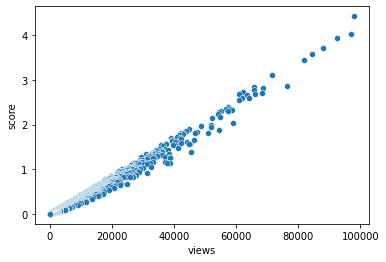

In [ ]:
sns.scatterplot(data=TrendingDf, x='views', y='score')

In [ ]:
moviesDf.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [ ]:
TrendingDf.reset_index(inplace=True)

<h3> Example of top recommendations by score

In [ ]:
recommendations = getTopK(by='score', k=10, df=TrendingDf)
print(recommendations)

['Shawshank Redemption, The', 'Forrest Gump', 'Pulp Fiction', 'Silence of the Lambs, The', 'Matrix, The', 'Star Wars: Episode IV - A New Hope', "Schindler's List", 'Jurassic Park', 'Fight Club', 'Braveheart']


<h3> Example of top recommendations by views 

In [ ]:
recommendations = getTopK(by='views', k=10, df=TrendingDf)
print(recommendations)

['Shawshank Redemption, The', 'Forrest Gump', 'Pulp Fiction', 'Silence of the Lambs, The', 'Matrix, The', 'Star Wars: Episode IV - A New Hope', 'Jurassic Park', "Schindler's List", 'Braveheart', 'Toy Story']


<h3> Example of top recommendations by rating (very bad idea)

In [ ]:
recommendations = getTopK(by='rating', k=10, df=TrendingDf)
print(recommendations)

['The 9-11 Hijackers - Inside The Hamburg Cell', 'Out on a Limb', 'Milton Glaser: To Inform & Delight', 'Catch That Girl', 'The Thursday', 'Meet Market', 'Going to the Mat', 'Hush Little Baby', 'Dusty and Sweets McGee', "Fred Rogers: America's Favorite Neighbor"]


## Evaluate popularity-based model 

now, let's get for each user the highest 15 movies that he liked. We will then make 15 recommendations, too.
Finally, we will see how many recommendations that we made were actually liked by the users 

Thus, our recommendations(same for all users) / user likes should give us how precise we are

this is Precision @ K, where K = 15

In [ ]:
#get top k rated movies for each user
top15 = ratingsDf.groupby('userId')['rating'].nlargest(15)

In [ ]:
top15 = pd.DataFrame(top15) #it returned a series, let's convert it to a dataframe 
top15.head() #let's see what we got

rating
userId           
1      3      4.5
       4      4.5
       7      4.5
       12     4.5
       8      4.0

In [ ]:
top15Copy = top15 #this doesn't create an actual copy, it copies the reference only (operating on the same data)
top15Copy.reset_index(inplace=True)
top15Copy.head()

,userId,level_1,rating
0,1,3,4.5
1,1,4,4.5
2,1,7,4.5
3,1,12,4.5
4,1,8,4.0


<h4> What is level_1? It is the index of the row that had the movie that the user liked

In [ ]:
ratingsDfcopy = ratingsDf.copy()
ratingsDfcopy.reset_index(inplace=True) #let's reset the index to be able to access the it as a regular column
ratingsDfcopy.head()

,index,userId,movieId,rating
0,0,1,307,3.5
1,1,1,481,3.5
2,2,1,1091,1.5
3,3,1,1257,4.5
4,4,1,1449,4.5


In [ ]:
#left join the top15 with the ratings dataframe on level1 from top15 and index from ratings
#this will give us the top 15 movies for each user
top15Copy = pd.merge(top15Copy, ratingsDfcopy[['movieId', 'index']], left_on='level_1', right_on='index')

In [ ]:
top15Copy.head()

,userId,level_1,rating,movieId,index
0,1,3,4.5,1257,3
1,1,4,4.5,1449,4
2,1,7,4.5,2134,7
3,1,12,4.5,3424,12
4,1,8,4.0,2478,8


In [ ]:
our_recommendations = TrendingDf['movieId'].head(15) #it is already sorted by score so we can just take the top 15
our_recommendations = our_recommendations.values.tolist() #convert to list for easy iteration

In [ ]:
counts = dict(top15Copy['movieId'].value_counts()) #count the number of times each movie was in the top 15 likes of each user
counter = 0
for recommendation in our_recommendations:
    counter += counts[recommendation] #add the number of times each movie was in the top 15 likes of each user

print("We made ", counter, " correct recommendations out of the ", top15Copy.shape[0], " we had to make")

print("Our precision when recommending 15 movies @ 15 top likes of each user is: ", counter/top15Copy.shape[0])

We made  538577  correct recommendations out of the  3768097  we had to make
Our precision when recommending 15 movies @ 15 top likes of each user is:  0.14293076850197858


## concluding on the popularity based approach 

we ended up with 14% for the precision@15. Not bad for a very simple policy like this, let's see if we can do better

# Content-based recommender

remember this genome scores? it was a set of 1128 scores per movie describing how relevant each tag is 

In [ ]:
genomeScoresDf.sample(5)

,movieId,tagId,relevance
14383293,157853,166,0.01775
9062860,33912,509,0.01725
691925,656,462,0.01625
13906110,133802,127,0.02100
4782662,4707,1071,0.12350


<h2> Let's review some concepts 

![image](https://media-exp1.licdn.com/dms/image/C5622AQHPmn4km9UfHw/feedshare-shrink_1280/0/1650370473474?e=2147483647&v=beta&t=4Y_OQExDRstFx-4P6nYLgWOIXfpia2T2oknKyV_o5C4)

we want to measure how close two movies are to each other, but we have tens of ways to measure distances

In this notebook, I will mainly use two methods (jaccard, and cosine similarity)

jaccard is simply observing in two sets, what is the intersection between them when compared to their union
It doesn't account for the score or the relevance of each component in the set.

It is very useful when comparing genres for example, since we don't have relevance score for each genre.

Cosine similarity on the other hand is measuring the angle between each two vectors (movies in this case)
and the smaller the angle, the closer these two movies are 

We will use it with the tags since we have a relevance score for each tag and can take it to a high dimension to measure similarity 

In [ ]:
def jaccard(a, b):
    a = set(a)
    b = set(b)
    return len(a.intersection(b)) / len(a.union(b))

let's take an example 


In [ ]:
a = ['mina', 'ashraf', 'is', 'a', 'tired']
b = ['mina', 'ashraf', 'is', 'trying', 'his', 'best']
jaccard(a, b)

0.375

let's now get the tags and their relevance into our dataframe so that we can use them 

In [ ]:
movieTags = genomeScoresDf.merge(genomeTagsDf, on='tagId').merge(moviesDf, on = 'movieId')
movieTags.head(7)

,movieId,tagId,relevance,tag,title,genres,year
0,1,1,0.02900,007,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,2,0.02375,007 (series),Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,1,3,0.05425,18th century,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
3,1,4,0.06875,1920s,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
4,1,5,0.16000,1930s,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
5,1,6,0.19525,1950s,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
6,1,7,0.07600,1960s,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995


this created a lot of redundancy, each year, genres, title, and movieId is now repeated over 1128 times in the data
So the question is now, should we really keep all 1128 tags?

In [ ]:
movieTags2 = movieTags
movieTags2['relevance_rank'] = movieTags2.groupby("movieId")["relevance"].rank(method = "first", ascending = False).astype('int64')
movieTags2.head(20)

,movieId,tagId,relevance,tag,title,genres,year,relevance_rank
0,1,1,0.02900,007,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,877
1,1,2,0.02375,007 (series),Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,942
2,1,3,0.05425,18th century,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,686
3,1,4,0.06875,1920s,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,606
4,1,5,0.16000,1930s,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,362
5,1,6,0.19525,1950s,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,300
6,1,7,0.07600,1960s,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,573
7,1,8,0.25200,1970s,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,222
8,1,9,0.22750,1980s,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,250
9,1,10,0.02400,19th century,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,934


<h4> As you can see, some tags are just not relevant at all. Let's only keep the first 60 tags

In [ ]:
movieTags2 = movieTags2[movieTags2['relevance_rank'] <= 60] 
#keeping 1128 for each movie is an overkill, I will keep the top 100 for each movie
print(movieTags2.shape)
movieTags2.head(10)

(790560, 8)


,movieId,tagId,relevance,tag,title,genres,year,relevance_rank
18,1,19,0.66825,action,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,49
28,1,29,0.90700,adventure,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,14
29,1,30,0.60850,affectionate,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,57
61,1,62,0.66025,animals,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,51
62,1,63,0.95500,animated,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,9
63,1,64,0.98875,animation,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,4
185,1,186,0.95850,cartoon,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,8
192,1,193,0.80350,cgi,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,29
202,1,203,0.90550,childhood,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,15
203,1,204,0.95450,children,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,10


now, let's take those 60 tags and convert them to a set

In [ ]:
moviesTagsList = movieTags2.groupby(['movieId'])['tag'].apply(set)
moviesTagsList.head()

movieId
1    {oscar (best directing), kids and family, anim...
2    {good action, saturn award (best special effec...
3    {catastrophe, culture clash, predictable, sequ...
4    {chick flick, catastrophe, weapons, heartwarmi...
5    {single father, catastrophe, culture clash, pr...
Name: tag, dtype: object

In [ ]:
moviesTagsList = pd.DataFrame(moviesTagsList).reset_index()
moviesTagsList.head()

,movieId,tag
0,1,"{oscar (best directing), kids and family, anim..."
1,2,"{good action, saturn award (best special effec..."
2,3,"{catastrophe, culture clash, predictable, sequ..."
3,4,"{chick flick, catastrophe, weapons, heartwarmi..."
4,5,"{single father, catastrophe, culture clash, pr..."


## Let's recommend to users based on Jaccard distance between the top 60 tags 

In [ ]:
def getRecommendations(k, id):
    
    x = moviesDf[moviesDf['movieId'] == id] #the id of the movie we want to get recommendations for
    if x.shape[0] == 0:
        return "Movie not found"
               
    print("Getting recommendations for: ", getMovieTitle(moviesDf, 'movieId', x))
    #let's get the movie tags
    movie = moviesTagsList[moviesTagsList['movieId'] == id]['tag'].values[0]
    
    movieNeighbors = moviesTagsList.copy() #copy all movies with their top tags set 

    #measure the jaccard similarity between the movie tags and the movie tags of each other movie
    movieNeighbors['jaccard'] = moviesTagsList['tag'].apply(lambda x: jaccard(x, movie))
    
    #let's sort them by the jaccard similarity and get the top k of them 
    movieNeighbors.sort_values('jaccard', ascending=False, inplace=True)

    movieNeighbors = movieNeighbors.head(k+1)
    recommendations = getTopK(by='jaccard', k=k, df=movieNeighbors)
    del movie, movieNeighbors
    gc.collect()
    return recommendations


In [ ]:
getRecommendations(k=10, id=1)

Getting recommendations for:  Toy Story


['Toy Story',
 'Monsters, Inc.',
 'Toy Story 2',
 "Bug's Life, A",
 'Finding Nemo',
 'Ratatouille',
 'Toy Story 3',
 'For the Birds',
 'Toy Story That Time Forgot',
 'Winnie the Pooh and Tigger Too']

<h3> getting Toy Story 2, Toy story 3, Finding nemo, Monsters Inc, etc as similar movies to Toy story is not bad at ALL.

![image](https://i.imgflip.com/mi1ql.jpg)

<h3> It is not that useful if you have to write the Id of the movie to get recommendations for it. 

Let's write a function that takes the name and returns the Id for us 

but people are bad at spelling, let's make it a little bit flexible 

In [ ]:
def get_neartest_names(name):
    names = moviesDf[moviesDf['title'].str.contains(name, case=False)]
    print(names.shape)
    if len(names) == 0:
        return "Movie not found"
    else:
        return names
    

In [ ]:
get_neartest_names("Dark knight")

(6, 4)


,movieId,title,genres,year
12559,58559,"Dark Knight, The",Action|Crime|Drama|IMAX,2008
18441,91529,"Dark Knight Rises, The",Action|Adventure|Crime|IMAX,2012
20030,98124,"Batman: The Dark Knight Returns, Part 1",Action|Animation|Sci-Fi,2012
20477,99813,"Batman: The Dark Knight Returns, Part 2",Action|Animation,2013
21474,103454,Batman Unmasked: The Psychology of the Dark Kn...,Documentary,2008
30286,130219,The Dark Knight,Action|Crime|Drama|Thriller,2011


In [ ]:
getRecommendations(10, 58559)

Getting recommendations for:  Dark Knight, The


['Dark Knight, The',
 'Batman Begins',
 'Dark Knight Rises, The',
 'Batman: The Dark Knight Returns, Part 2',
 'Batman',
 'Batman Beyond: Return of the Joker',
 'Superman/Batman: Apocalypse',
 'Batman: Mystery of the Batwoman',
 'Batman: Under the Red Hood',
 'Justice League: Crisis on Two Earths']

<h3> Honestly, I am very impressed by the recommendations it is making so far </h3>

![image](https://c.tenor.com/-gS-ft4nRzkAAAAC/interesting-batman.gif)

## Can we make it even better ? 😈

## let's test cosine similarity with TF-IDF

we have already stuided Tf-IDF in coursera's course, it is very intersting concept to measure document similarity. We have a set of tags (21 tags), and each movie has a combination of them. some tags are just very popular, and some are not, and this is reflected on the similarity metric as sometimes you fail to recommend rare combinations of tags 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
moviesDf['genres'] = moviesDf['genres'].str.replace('|',' ')
moviesDf['genres'] = moviesDf['genres'].str.replace('Sci-Fi','SciFi')
moviesDf['genres'] = moviesDf['genres'].str.replace('Film-Noir','Noir')

C:\Users\minaa\AppData\Local\Temp\ipykernel_14468\1211086201.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  moviesDf['genres'] = moviesDf['genres'].str.replace('|',' ')


In [ ]:
tfidfVector = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidfVector.fit_transform(moviesDf['genres'])
print(list(enumerate(tfidfVector.get_feature_names_out())))


[(0, 'action'), (1, 'adventure'), (2, 'animation'), (3, 'children'), (4, 'comedy'), (5, 'crime'), (6, 'documentary'), (7, 'drama'), (8, 'fantasy'), (9, 'genres'), (10, 'horror'), (11, 'imax'), (12, 'listed'), (13, 'musical'), (14, 'mystery'), (15, 'noir'), (16, 'romance'), (17, 'scifi'), (18, 'thriller'), (19, 'war'), (20, 'western')]


now the tf-idf matrix has for each row, the corresponding score with each tag

so here, movie 0 has a score of 0.49 with tag 8, 0.489 with tag 3 (children), and 0.493 (animation)

remeber movie 0 was toy story, so we are doing a great job so far

In [ ]:
print(tfidf_matrix[0:1])

  (0, 8)	0.49457171435245356
  (0, 4)	0.277039867342963
  (0, 3)	0.4895464012695515
  (0, 2)	0.493386362643742
  (0, 1)	0.4422238679970559


In [ ]:
print(len(movieTags['movieId'].unique())) 
#there are 13176 tags in general, but each movie has 1128 and we have 58000 movies
#something is missing
print(len(moviesDf['movieId'].unique()))
print(len(genomeScoresDf['movieId'].unique()))

13176
58098
13176


each tag is found exactly 13176 times, it appears that the tags are provided for only a subset of the 58k movies, but it is fine 

In [ ]:
movieTags.groupby('tag')['tag'].count()

tag
007             13176
007 (series)    13176
18th century    13176
1920s           13176
1930s           13176
                ...  
writing         13176
wuxia           13176
wwii            13176
zombie          13176
zombies         13176
Name: tag, Length: 1128, dtype: int64

I wrote 2 functions to measure the cosine similarity between two movies

if you are interested, argpartition provides an effeicnt way to find the top k elements from an array in O(N) complexity without sorting. it is better than argsort if you are going to use it less than log N times 

which is the case since we are going to use each movie results only once

In [ ]:
def get_cosine_sim_tfidf(movieId, tfidf_matrix):
    row = tfidf_matrix.getrow(movieId-1)
    #print("row in tf-idf: ", row)
    #print("row in tf-idf: ", row.shape)
    #print("tf-idf matrix: ", tfidf_matrix.shape)
    sim_scores = linear_kernel(row, tfidf_matrix)
    return sim_scores


def get_top_k_cosinSim(movieId, tfidf_matrix, k):
    sim_scores = get_cosine_sim_tfidf(movieId, tfidf_matrix)
    #reshape simscore to (n,)
    sim_scores = sim_scores.reshape(sim_scores.shape[1])
    
    indices = np.argpartition(sim_scores, -k)[-k:]
    #loop in reverse order to get the highest k
    for i in reversed(indices):
        print(moviesDf.iloc[i]['title'])

get_top_k_cosinSim(movieId=1, tfidf_matrix=tfidf_matrix, k=15)

Toy Story
Toy Story Toons: Hawaiian Vacation
Toy Story Toons: Small Fry
The Magic Crystal
Asterix and the Vikings (Astérix et les Vikings)
Puss in Book: Trapped in an Epic Tale
Moana
Tale of Despereaux, The
Brother Bear 2
The Dragon Spell
Tangled: Before Ever After
Boxtrolls, The
Aladdin
The Good Dinosaur
Adventures of Rocky and Bullwinkle, The


again, it captures very good relationships. we can see that it recommends very related movies and short films that the previous model failed to capture 

## one more trial

In [ ]:
#groupby movieId and extract tags with their relevance
movieTagsx = movieTags.groupby(['movieId', 'tag'])['relevance'].max().reset_index()
movieTagsx.head()

,movieId,tag,relevance
0,1,007,0.02900
1,1,007 (series),0.02375
2,1,18th century,0.05425
3,1,1920s,0.06875
4,1,1930s,0.16000


In [ ]:
#group by movie and store tag and relevance in a dictionary
movieTagsDict = movieTagsx.groupby('movieId').apply(lambda row: dict(zip(row['tag'], row['relevance'])))


In [ ]:
movieTagsDictDf = pd.DataFrame(movieTagsDict)

movieTagsDictDf.reset_index()


,movieId,0
0,1,"{'007': 0.029, '007 (series)': 0.0237499999999..."
1,2,"{'007': 0.03625, '007 (series)': 0.03625, '18t..."
2,3,"{'007': 0.0414999999999999, '007 (series)': 0...."
3,4,"{'007': 0.0334999999999999, '007 (series)': 0...."
4,5,"{'007': 0.0404999999999999, '007 (series)': 0...."
...,...,...
13171,185435,"{'007': 0.10625, '007 (series)': 0.10775, '18t..."
13172,185585,"{'007': 0.0424999999999999, '007 (series)': 0...."
13173,186587,"{'007': 0.0895, '007 (series)': 0.09125, '18th..."
13174,187593,"{'007': 0.0544999999999999, '007 (series)': 0...."


In [ ]:
#rename second column to tag
movieTagsDictDf.rename(columns={0: 'tag'}, inplace=True)
movieTagsDictDf.head()

,tag
movieId,
1,"{'007': 0.029, '007 (series)': 0.0237499999999..."
2,"{'007': 0.03625, '007 (series)': 0.03625, '18t..."
3,"{'007': 0.0414999999999999, '007 (series)': 0...."
4,"{'007': 0.0334999999999999, '007 (series)': 0...."
5,"{'007': 0.0404999999999999, '007 (series)': 0...."


In [ ]:
#convert dictionary to dataframe
pd.DataFrame.from_dict([movieTagsDictDf['tag'].values[0]])

,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
0,0.029,0.02375,0.05425,0.06875,0.16,0.19525,0.076,0.252,0.2275,0.024,...,0.03775,0.0225,0.04075,0.03175,0.1295,0.0455,0.02,0.0385,0.09125,0.02225


In [ ]:
movieTagsDictDf = pd.concat(
    [movieTagsDictDf['tag'].apply(pd.Series).add_prefix(c + "_") for c in movieTagsDictDf], axis=1
)

In [ ]:
movieTagsDictDf.head()

,tag_007,tag_007 (series),tag_18th century,tag_1920s,tag_1930s,tag_1950s,tag_1960s,tag_1970s,tag_1980s,tag_19th century,...,tag_world politics,tag_world war i,tag_world war ii,tag_writer's life,tag_writers,tag_writing,tag_wuxia,tag_wwii,tag_zombie,tag_zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,...,0.03775,0.02250,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225
2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,...,0.04775,0.02050,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850
3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,...,0.05800,0.02375,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750
4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,...,0.04900,0.03275,0.02125,0.03675,0.15925,0.05225,0.01500,0.01600,0.09175,0.01500
5,0.04050,0.05175,0.03600,0.04625,0.05500,0.08000,0.02150,0.07375,0.02825,0.02375,...,0.05375,0.02625,0.02050,0.02125,0.17725,0.02050,0.01500,0.01550,0.08875,0.01575


<h2> Now, we have a the tags on the columns, and the values in the dataframe, let's find the nearest nighebours from each tag using cosine distance without the tf-idf.


In [ ]:
#knn classifier for movie recommendation
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=11, algorithm='auto', metric='cosine')
x = movieTagsDictDf.iloc[:,0:].values
knn.fit(x)

NearestNeighbors(metric='cosine', n_neighbors=11)

In [ ]:
toyStory = movieTagsDictDf.iloc[0,0:]

toyStoryNeighbors = knn.kneighbors([toyStory], return_distance=False)

In [ ]:
toyStoryNeighbors

array([[    0,  4406,  2809,  2097, 10235,  5611,  8742,  7111,  9746,
         4692,  3869]], dtype=int64)

In [ ]:
ids = movieTagsDictDf.iloc[toyStoryNeighbors[0]].index.values
for id in ids:
    print(moviesDf[moviesDf['movieId'] == id]['title'].values[0])

Toy Story
Monsters, Inc.
Toy Story 2
Bug's Life, A
Toy Story 3
Finding Nemo
Ratatouille
Incredibles, The
Up
Ice Age
Shrek


![image](https://memegenerator.net/img/instances/65958106.jpg)

In [ ]:
print(len(ratingsDf['userId'].unique()))

283228


<h3> one more test

In [ ]:
get_neartest_names("Godfather")

(16, 4)


,movieId,title,genres,year
843,858,"Godfather, The",Crime Drama,1972
1195,1221,"Godfather: Part II, The",Crime Drama,1974
1940,2023,"Godfather: Part III, The",Crime Drama Mystery Thriller,1990
7924,8607,Tokyo Godfathers,Adventure Animation Drama,2003
8494,25934,3 Godfathers,Drama Western,1948
20593,100180,"Last Godfather, The",Comedy,2010
22444,106704,Disco Godfather,Action Crime Drama,1979
26949,121519,The New Godfathers,Crime,1979
27988,123880,The Black Godfather,Action Crime Thriller,1974
28387,124791,Three Godfathers,Drama Western,1936


In [ ]:
movieTagsDictDf2 = movieTagsDictDf.copy()
movieTagsDictDf2.reset_index(inplace=True)
movieTagsDictDf2.head()

,movieId,tag_007,tag_007 (series),tag_18th century,tag_1920s,tag_1930s,tag_1950s,tag_1960s,tag_1970s,tag_1980s,...,tag_world politics,tag_world war i,tag_world war ii,tag_writer's life,tag_writers,tag_writing,tag_wuxia,tag_wwii,tag_zombie,tag_zombies
0,1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,...,0.03775,0.02250,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225
1,2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,...,0.04775,0.02050,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850
2,3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,...,0.05800,0.02375,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750
3,4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,...,0.04900,0.03275,0.02125,0.03675,0.15925,0.05225,0.01500,0.01600,0.09175,0.01500
4,5,0.04050,0.05175,0.03600,0.04625,0.05500,0.08000,0.02150,0.07375,0.02825,...,0.05375,0.02625,0.02050,0.02125,0.17725,0.02050,0.01500,0.01550,0.08875,0.01575


In [ ]:
movieTagsDictDf2[movieTagsDictDf2['movieId'] == 858]

,movieId,tag_007,tag_007 (series),tag_18th century,tag_1920s,tag_1930s,tag_1950s,tag_1960s,tag_1970s,tag_1980s,...,tag_world politics,tag_world war i,tag_world war ii,tag_writer's life,tag_writers,tag_writing,tag_wuxia,tag_wwii,tag_zombie,tag_zombies
777,858,0.02225,0.01925,0.0575,0.204,0.3225,0.24225,0.09075,0.4375,0.101,...,0.19625,0.052,0.19475,0.04125,0.13825,0.142,0.04725,0.101,0.074,0.02275


In [ ]:
godfather = movieTagsDictDfvery.iloc[777,:]
godfatherNeighbors = knn.kneighbors([godfather], return_distance=False)
ids = movieTagsDictDf.iloc[godfatherNeighbors[0]].index.values
for id in ids:
    print(moviesDf[moviesDf['movieId'] == id]['title'].values[0])

Godfather, The
Godfather: Part II, The
The Godfather Trilogy: 1972-1990
Goodfellas
Departed, The
On the Waterfront
Road to Perdition
Scarface
Untouchables, The
Unforgiven
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il)



very very good recommnedations 


![image](https://memegenerator.net/img/instances/51636299.jpg)

## What do users like? 
you can't just keep recommending movies when a user writes explicitly a movie that he wants to see similar movies to. We need now to "summarize" user prefernces, and then find a movie that matches their summarized likes. 

In [ ]:
ratingsDf.groupby('userId')['rating'].mean().describe()

count    283228.000000
mean          3.635359
std           0.582801
min           0.500000
25%           3.323529
50%           3.666667
75%           4.000000
max           5.000000
Name: rating, dtype: float64

<h3> Just like AUC professors, some are easy raters, and some are very tough raters that are not easily satisfied

In [ ]:
#you can notice clearly that some people are just very easy raters, they like everything they watch, and some others 
#are very hard raters, they like nothing. 
ratingsDfcopy = ratingsDf.copy()
means = ratingsDfcopy.groupby('userId')['rating'].transform('mean')
stds = ratingsDfcopy.groupby('userId')['rating'].transform('std')
ratingsDfcopy['avg'] = means
ratingsDfcopy['std'] = stds
ratingsDfcopy['rating_n'] = ratingsDfcopy['rating'] - means
ratingsDfcopy['rating_n'] = ratingsDfcopy['rating_n'] / stds
ratingsDfcopy.sample(10)

,userId,movieId,rating,avg,std,rating_n
14237562,145719,1270,4.0,3.990642,0.666545,0.014040
18664753,190349,1961,4.0,3.333333,1.154701,0.577350
19097314,194856,8961,5.0,3.750000,1.163090,1.074724
24256100,248042,6890,5.0,3.710177,1.134835,1.136573
40199,384,51540,4.0,3.162338,1.301145,0.643789
15296924,156277,3633,5.0,3.589984,1.003580,1.404986
13843550,141682,4306,5.0,4.637255,0.459113,0.790101
20590309,210228,168,3.0,2.927798,1.050459,0.068734
24883036,254219,1036,4.0,3.340637,1.071078,0.615607
1992358,20399,688,4.0,1.888545,0.912283,2.314475


In [ ]:
ratingsDfcopy.drop(['rating', 'avg', 'std'], axis=1, inplace=True)

In [ ]:
ratingsDfcopy.head()

,userId,movieId,rating_n
0,1,307,0.179114
1,1,481,0.179114
2,1,1091,-1.731433
3,1,1257,1.134387
4,1,1449,1.134387


In [ ]:
movieTagsDictDf.head(2)
mvTg = movieTagsDictDf.copy()
mvTg.reset_index(inplace=True)

## Creating a user profile

so far, we recommended movies based on similar movies, but a user is not a movie, you cannot use the user to get recommendations, yet. 

Let's create a user profile based on the movies he liked and his ratings to get recommendations to him 

In [ ]:
#get row as a dictionary from dataframe
def get_row_dict(row):
    return dict(row.items())
#remove key from dictionary
def remove_key(d, key):
    r = dict(d)
    del r[key]
    return r


def get_movie_vec(movieId):
    movieId = int(movieId)
    return get_row_dict(mvTg[mvTg['movieId'] == movieId].head(1))
def user_vector(userId):
    user_ratings = ratingsDfcopy[ratingsDfcopy['userId'] == userId]
    user_dict = {}
    for index, row in user_ratings.iterrows():
        #apply key value add to dictionary
        movieVec = get_movie_vec(row['movieId'])
        movie_dict = get_row_dict(movieVec)
        #multiply all values by the rating
        for key, value in movie_dict.items():
            
            #v = value.values[0]
            v = value.to_numpy()
            if v.shape[0] > 0:
                v = v[0]
            else:
                v = 0
            if key in user_dict:                
                user_dict[key] += v * row['rating_n']
            else:
                user_dict[key] = v * row['rating_n']
                
    user_dict = remove_key(user_dict, 'movieId')
    return user_dict



In [ ]:
u5 = user_vector(5)

In [ ]:
#dict to pandas series
user = pd.Series(u5)
userNeighbors = knn.kneighbors([user], return_distance=False)


In [ ]:
ids = movieTagsDictDf.iloc[userNeighbors[0]].index.values
u5_recommendations = []
for id in ids:
    u5_recommendations.append(moviesDf[moviesDf['movieId'] == id]['title'].values[0])
u5_recommendations

['Fight Club',
 'Shawshank Redemption, The',
 'City of God (Cidade de Deus)',
 'Pulp Fiction',
 'Goodfellas',
 "One Flew Over the Cuckoo's Nest",
 'American Beauty',
 'There Will Be Blood',
 'Citizen Kane',
 'Eternal Sunshine of the Spotless Mind',
 'Memento']

In [ ]:
#now let's actually see the movies that user 5 liked 
#and the movies that user 5 did not like

u5Viewed = ratingsDfcopy[ratingsDfcopy['userId'] == 5].sort_values(by='rating_n', ascending=False)

In [ ]:
u5Liked = []
i = 0
for index, row in u5Viewed.iterrows():
    if i < 50:
        u5Liked.append(moviesDf[moviesDf['movieId'] == row['movieId']]['title'].values[0])
    i+=1

In [ ]:
u5Liked

['Full Metal Jacket',
 'Goodfellas',
 'Pianist, The',
 'City of God (Cidade de Deus)',
 'Eternal Sunshine of the Spotless Mind',
 'Usual Suspects, The',
 'American Beauty',
 'Thank You for Smoking',
 'Stranger than Fiction',
 'Big Lebowski, The',
 "Amelie (Fabuleux destin d'Amélie Poulain, Le)",
 'Memento',
 'Trainspotting',
 'Into the Wild',
 'Shawshank Redemption, The',
 'Pulp Fiction',
 'Juno',
 'Children of Men',
 'Letters from Iwo Jima',
 'Departed, The',
 'This Is England',
 '3:10 to Yuma',
 'Sin City',
 'The Machinist',
 'No Country for Old Men',
 'Scratch',
 'Garden State',
 'There Will Be Blood',
 'When We Were Kings',
 'Godfather, The',
 'Snatch',
 'L.A. Confidential',
 'Fight Club',
 'American History X',
 "Schindler's List",
 'Eastern Promises',
 'Superbad',
 'Gone Baby Gone',
 'Bourne Ultimatum, The',
 'Tsotsi',
 'Hot Fuzz',
 'Blood Diamond',
 'Casino Royale',
 'Prestige, The',
 "One Flew Over the Cuckoo's Nest",
 'Little Children',
 'American Gangster',
 "Pan's Labyrinth 

In [ ]:
#you can see that user 5 watched in general 72 movies
print("User 5 watched: " , len(ratingsDf[ratingsDf['userId'] == 5]))
#print intersection of liked and not liked movies
print("and out of the 10 recommendation we made, he would have liked: " , len(set(u5Liked).intersection(u5_recommendations)))
print(set(u5Liked).intersection(u5_recommendations))

User 5 watched:  72
and out of the 10 recommendation we made, he would have liked:  10
{'Goodfellas', 'Memento', 'Fight Club', 'Eternal Sunshine of the Spotless Mind', 'City of God (Cidade de Deus)', 'American Beauty', 'There Will Be Blood', "One Flew Over the Cuckoo's Nest", 'Shawshank Redemption, The', 'Pulp Fiction'}


In [ ]:
def recommend_for_user(userid):
    user = pd.Series(user_vector(userid))
    userNeighbors = knn.kneighbors([user], return_distance=False)
    ids = movieTagsDictDf.iloc[userNeighbors[0]].index.values
    u_recommendations = []
    for id in ids:
        u_recommendations.append(moviesDf[moviesDf['movieId'] == id]['title'].values[0])
    return u_recommendations

def jaccard_similarity(userid, k, our_recommendations, verbose=False):    
    user_Liked = []
    our_recommendations = set(our_recommendations)
    user_viewed = ratingsDfcopy[ratingsDfcopy['userId'] == userid].sort_values(by='rating_n', ascending=False)
    i = 0
    for _ , row in user_viewed.iterrows():
        if i < k:
            user_Liked.append(moviesDf[moviesDf['movieId'] == row['movieId']]['title'].values[0])
        i+=1
    
    user_Liked = set(user_Liked)
    intersection = user_Liked.intersection(our_recommendations)
    if verbose:
        print("User: " , userid)
        print("User liked: " , user_Liked)
        print("Our recommendations: " , our_recommendations)
        print("Intersection: " , intersection)
    return len(intersection)
    

In [ ]:
uid = 30
k = 10 #precision @ k
urec = recommend_for_user(uid)
jaccard_similarity(uid, k, urec, verbose=True)

User:  30
User liked:  {'Ronin', 'Some Like It Hot', 'Maltese Falcon, The', 'Godfather: Part III, The', 'Manchurian Candidate, The', 'Vertigo', "Dracula (Bram Stoker's Dracula)", 'Birds, The', 'Goldfinger', 'Animal House'}
Our recommendations:  {'Maltese Falcon, The', 'Manchurian Candidate, The', 'Vertigo', 'Laura', 'Double Indemnity', 'Big Sleep, The', 'Dial M for Murder', 'Touch of Evil', 'Strangers on a Train', 'Diabolique (Les diaboliques)', 'Chinatown'}
Intersection:  {'Maltese Falcon, The', 'Vertigo', 'Manchurian Candidate, The'}


3

In [ ]:
uid = 1007
k = 10 #precision @ k
urec = recommend_for_user(uid)
jaccard_similarity(uid, k, urec, verbose=True)

User:  1007
User liked:  {'Forrest Gump', 'Pretty Woman', 'Sleepless in Seattle', 'Aladdin', 'Dave', 'Night to Remember, A', 'Steel Magnolias', 'Election', 'Good Will Hunting', 'Father of the Bride'}
Our recommendations:  {'On Golden Pond', 'Pretty Woman', "You've Got Mail", 'Notebook, The', 'Sleepless in Seattle', 'Magic of Belle Isle, The', 'Return to Me', 'Officer and a Gentleman, An', 'Steel Magnolias', 'Other Sister, The', 'Jerry Maguire'}
Intersection:  {'Pretty Woman', 'Steel Magnolias', 'Sleepless in Seattle'}


3

In [ ]:
uid = 4444
k = 30 #precision @ k
urec = recommend_for_user(uid)
jaccard_similarity(uid, k, urec, verbose=True)

User:  4444
User liked:  {'Usual Suspects, The', 'Silence of the Lambs, The', 'Godfather, The', 'Boot, Das (Boat, The)', 'Star Trek: First Contact', 'Matrix, The', 'Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il)', 'Life Is Beautiful (La Vita è bella)', 'Killing Fields, The', 'Shawshank Redemption, The', 'WarGames', 'Aliens', 'Godfather: Part II, The', 'Seven Samurai (Shichinin no samurai)', 'Seven (a.k.a. Se7en)', 'Fight Club', 'Capitalism: A Love Story', 'Hotel Rwanda', 'Pulp Fiction', 'Godfather: Part III, The', 'Memento', 'Avatar', 'Jurassic Park', 'Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The', 'Dragonheart', "One Flew Over the Cuckoo's Nest", 'Wonderful Days (a.k.a. Sky Blue)', 'Dark Knight, The', 'Blade Runner', 'American Beauty'}
Our recommendations:  {'Citizen Kane', 'Godfather: Part II, The', 'Hustler, The', 'On the Waterfront', 'The Godfather Trilogy: 1972-1990', 'Godfather, The', "Schindler's List", '12 Angry Men', "One Flew Over th

4

In [ ]:
#knn classifier for movie recommendation
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=15, algorithm='auto', metric='cosine')
x = movieTagsDictDf.iloc[:,0:].values
knn.fit(x)



NearestNeighbors(metric='cosine', n_neighbors=15)

In [ ]:
sampleUserIds = ratingsDfcopy['userId'].unique()
#pick random samples from sampleUserIds
sampleUserIds = sampleUserIds[np.random.randint(0, len(sampleUserIds), size=20)]
sampleUserIds

array([130787, 127988, 170094, 145858, 101379, 191162, 239904,  31157,
        22834, 135906,  71275, 161162, 170520, 129769, 180243,  75759,
       250204,  71971, 105913, 110318], dtype=int64)

# Evaluate content-based models with user vector idea

In [ ]:
scores = []
from tqdm import tqdm_notebook 
#generate 1000 random user ids
k = 30
for i in tqdm_notebook(sampleUserIds):
    uid = i 
    urec = recommend_for_user(uid)
    scores.append(jaccard_similarity(uid, k, urec, verbose=False))

avg = sum(scores) / len(scores)
print("Average Jaccard Similarity: " , avg)



C:\Users\minaa\AppData\Local\Temp\ipykernel_14468\2839705918.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(sampleUserIds):


  0%|          | 0/20 [00:00<?, ?it/s]

Average Jaccard Similarity:  1.65


<h3> It is very computationally consuming to run our recommendation function for each user in the dataset, as it takes roughly 2.5 seconds per user to get recommendations for him and we have 280,000 users. I will pick a random sample and evaluate our score against them 

In [ ]:
scores = []
sampleUserIds = ratingsDfcopy['userId'].unique()
#pick random samples from sampleUserIds
sampleUserIds = sampleUserIds[np.random.randint(0, len(sampleUserIds), size=30)]
from tqdm import tqdm_notebook 
#generate 1000 random user ids
k = 30
for i in tqdm_notebook(sampleUserIds):
    uid = i 
    urec = recommend_for_user(uid)
    scores.append(jaccard_similarity(uid, k, urec, verbose=False))

avg = sum(scores) / len(scores)
print("We matched: ", sum(scores), " Out of the ", len(scores)*15, " recommendations")
print("Average Jaccard Similarity: " , avg)



C:\Users\minaa\AppData\Local\Temp\ipykernel_14468\697659873.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(sampleUserIds):


  0%|          | 0/30 [00:00<?, ?it/s]

We matched:  79  Out of the  450  recommendations
Average Jaccard Similarity:  2.6333333333333333


In [ ]:
print ("Our precision@15 is ", sum(scores) / len(scores) /15)

Our precision@15 is  0.17555555555555555


<h4> The user vector was a good idea with bad performance. Apparently, it gets averaged out when the user has rated a lot of movies and the jaccard similarity tends to drop </h4>

![image](https://www.memecreator.org/static/images/memes/5421334.jpg)

# Collaborative filtering model

## Memory-based collaborative filtering models 

the easy way to go here is to fill null values with zeroes, and calculate the pearson correlation between items to get item-item CF, or between users to get user-user CF, which performs much worse, but this is not our problem now.

The problem is that this doesn't scale as it needs terabytes of memory to store 58000 * 58000 (movies-movies)

to know exactly how much memory we would need, 58,000 * 58,000 * 8 bytes (float) = 26912000000 bytes = 26.912 Gigabytes

I don't know about you, but my computer doesn't have this amount of memory, so I will do it in a more memory efficent approach at the price of speed and computation.

when we want to get recommedations to user x, I will compute the distance between his ratings vector to all other users ratings one by one (so there is no need to store them simulatenously in the memory), and get the highest few users similar to him.

In [ ]:
#create user-item matrix sparse matrix
from scipy import sparse

def create_user_item_matrix(ratingsDf):
    user_item_matrix = sparse.coo_matrix((ratingsDf['rating_n'], (ratingsDf['userId'], ratingsDf['movieId'])))
    user_item_matrix = user_item_matrix.tocsr()
    return user_item_matrix

In [ ]:
user_movie_matrix = create_user_item_matrix(ratingsDfcopy)
user_movie_matrix.shape

(283229, 193887)

In [ ]:
user_movie_matrix.getrow(5).toarray();

array([[0., 0., 0., ..., 0., 0., 0.]])

I thought that sklearn supports KNN on sparse matrices, but I couldn't get it to run at all. If you know how, please reach out 

I found this module (pysparnn) from facebook research that does approximate nearest neighbours search on sparse matrices, but it was very very slow, and I couldn't get it to work as intended. 

So I implemented my own, because my mama didn't raise a quitter  

In [ ]:

'''
#knn model on the sparse user_movie_matrix
import pysparnn.cluster_index as ci

data_to_return = range(1)
cp = ci.MultiClusterIndex(user_movie_matrix, data_to_return)

cp.search(user_movie_matrix[:0], k=1, return_distance=False)
'''


'\n#knn model on the sparse user_movie_matrix\nimport pysparnn.cluster_index as ci\n\ndata_to_return = range(1)\ncp = ci.MultiClusterIndex(user_movie_matrix, data_to_return)\n\ncp.search(user_movie_matrix[:0], k=1, return_distance=False)\n'

In [ ]:
count = 0
for i in user_movie_matrix.getrow(5).toarray()[0]:
    if i != 0:
        print(i, count)
    count+=1
    if count > 400:
        break

-0.4540151638743565 47
1.2664633518600446 50
-1.314254421741557 293
1.2664633518600446 296
1.2664633518600446 318


In [ ]:
ratingsDfcopy[ratingsDfcopy['userId'] == 5].sort_values(by='movieId', ascending=True)

,userId,movieId,rating_n
778,5,47,-0.454015
779,5,50,1.266463
780,5,293,-1.314254
781,5,296,1.266463
782,5,318,1.266463
...,...,...,...
845,5,55290,-0.454015
846,5,55765,-0.454015
847,5,55820,0.406224
848,5,56367,1.266463


In [ ]:
import scipy.spatial.distance 
from tqdm.notebook import tqdm_notebook
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

def _get_top_similar_cf(model, id, matrix, k):
    similarities = []
    if model == 'item':
        our_item = matrix.getcol(id).toarray()
        print(our_item.shape)
        print(matrix.shape)
        cosine_similarity_matrix = 1 - pairwise_distances(our_item, matrix, metric='cosine') 
        
        #topK = np.argpartition(cosine_similarity_matrix, -k)[-k:]
        print(cosine_similarity_matrix.shape)
        topK = []
        return topK
    elif model == 'user':
        our_user = matrix.getrow(id).toarray()
        print(our_user.shape)
        print(matrix.shape)
        cosine_similarity_matrix = 1- pairwise_distances(our_user,matrix,  metric='cosine') 
        #topK = np.argpartition(similarities, -k)[-k:]
        print(cosine_similarity_matrix.shape)
        topK = []
        return topK
    else:
        return []   


def get_top_similar_cf(model, id, matrix, k):
    similarities = []
    if model == 'item':
        our_item = matrix.getcol(id).toarray()[0].T
        for i in tqdm_notebook(range(ratingsDfcopy['movieId'].nunique())):
                comparison_item = matrix.getcol(i).toarray()[0].T
                similarity = 1 - scipy.spatial.distance.cosine(our_item, comparison_item)
                similarities.append((similarity))
        topK = np.argpartition(similarities, -k)[-k:]
        return topK
    elif model == 'user':
        our_user = matrix.getrow(id).toarray()[0]
        print(our_user)
        for i in tqdm_notebook(range(ratingsDfcopy['userId'].nunique())):
                comparison_user = matrix.getrow(i).toarray()[0]
                similarity = 1 - scipy.spatial.distance.cosine(our_user, comparison_user)
                similarities.append((similarity))
        topK = np.argpartition(similarities, -k)[-k:]
        return topK
    else:
        return []


this next cell will get you the top neart k neighbours, but it is very very slow.
Run it on your own  


The above code can apply item-item collaborative filtering on matrices columns, and user-user collaborative filtering on user-user rows 

In [ ]:
#top = get_top_similar_cf(model='user', id=10, matrix=user_movie_matrix, k=10)
#top

you probably noticed that I have transformed the ratings by subtracting the mean and dividing by the std per user for all movie ratings to make it up for tough or easy raters 

In [ ]:
ratingsDfcopy.sort_values(by=['userId', 'movieId']).head(10)

,userId,movieId,rating_n
0,1,307,0.179114
1,1,481,0.179114
2,1,1091,-1.731433
3,1,1257,1.134387
4,1,1449,1.134387
5,1,1590,-0.776160
6,1,1591,-1.731433
7,1,2134,1.134387
8,1,2478,0.656751
9,1,2840,-0.298523


so far, you clearly noticed that the memory-based CF fails to scale due to the heavy computations we need to make.

let's see another way 

### This doesn't scale

I will make my data much smaller in order to illustrate my idea

In [ ]:
#to explain the idea to you, I will use a much smaller dataset 
small_data = ratingsDf.sample(frac=0.0008, random_state=42)
print(small_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22203 entries, 26261418 to 2156668
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   22203 non-null  int64  
 1   movieId  22203 non-null  int64  
 2   rating   22203 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 693.8 KB
None


In [ ]:
#import train_test_split
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(small_data, test_size=0.2)

#dataframe to matrix 


train_data_matrix = train_data.to_numpy()
test_data_matrix = test_data.to_numpy()

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(17762, 3)
(4441, 3)


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[1.         0.79283325 0.8088982  0.79887067]
 [0.79283325 1.         0.99964005 0.99995029]
 [0.8088982  0.99964005 1.         0.99985787]
 [0.79887067 0.99995029 0.99985787 1.        ]]


In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])


[[1.00000000e+00 1.15296649e-02 7.86728896e-03]
 [1.15296649e-02 1.00000000e+00 9.21387985e-04]
 [7.86728896e-03 9.21387985e-04 1.00000000e+00]]


source: https://github.com/khanhnamle1994/movielens/blob/master/Content_Based_and_Collaborative_Filtering_Models.ipynb 
for this next 2 functions  

In [ ]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [ ]:
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 61186.32388574864
Item-based CF RMSE: 71106.22453843542


In [ ]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 38813.92267804584
Item-based CF RMSE: 2114.5877116130873


In [ ]:

gc.collect()

5207

the RMSE is very bad, but remeber we took a very very small subset of the original data to be able to find the similarity matrix easily and within the limited memory 

My approach was better as it will always find the absolute nearest k neighbours and make predictions based on them 

it didn't require much memory, but it was very very very very slow 

I feel like it is a research topic, so I am not willing to go that way due to time limitations

## Latent Factors model (Matrix factorization using SVD)

In [ ]:
small_data

,userId,movieId,rating
26261418,268200,2011,5.0
12418727,127230,1527,3.5
24553679,251068,1396,3.5
6965790,71485,3398,4.5
8945025,92393,20,3.0
...,...,...,...
8725319,89927,1722,1.5
9961257,102606,41569,4.0
16863130,172383,60684,3.5
21243197,217015,1527,5.0


In [ ]:
from scipy.sparse.linalg import svds
user_ratingsdf = small_data.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
user_ratingsdf.sample(20)

movieId,1,2,3,4,5,6,7,8,9,10,...,187531,187541,187593,188301,189065,189333,189363,192959,192979,193061
userId,,,,,,,,,,,,,,,,,,,,,
274008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_ratingsdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18647 entries, 42 to 283199
Columns: 5318 entries, 1 to 193061
dtypes: float64(5318)
memory usage: 756.7 MB


In [ ]:
#dataframe to matrix 
user_rating_matrix = user_ratingsdf.to_numpy()

In [ ]:
userRating = user_ratingsdf.to_numpy()
user_ratings_mean = np.mean(userRating, axis = 1)
Ratings_demeaned = userRating - user_ratings_mean.reshape(-1, 1)

U, sigma, Vt = svds(Ratings_demeaned, k = 50)
sigma = np.diag(sigma)


In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)


In [ ]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = user_ratingsdf.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,187531,187541,187593,188301,189065,189333,189363,192959,192979,193061
0,-0.000268,0.000821,0.000861,0.000834,0.000860,0.000724,0.000861,0.000859,0.000859,0.000886,...,0.000859,0.000859,0.000859,0.000859,0.000859,0.000859,0.000859,0.000859,0.000859,0.000859
1,-0.000041,0.000553,0.000572,0.000557,0.000572,0.000504,0.000572,0.000571,0.000571,0.000585,...,0.000571,0.000571,0.000571,0.000571,0.000571,0.000571,0.000571,0.000571,0.000571,0.000571
2,-0.000163,0.000363,0.000383,0.000370,0.000383,0.000314,0.000384,0.000382,0.000382,0.000396,...,0.000383,0.000382,0.000382,0.000382,0.000382,0.000382,0.000382,0.000382,0.000383,0.000383
3,-0.000415,0.000877,0.000932,0.000903,0.000932,0.000705,0.000932,0.000933,0.000933,0.000907,...,0.000933,0.000933,0.000933,0.000933,0.000933,0.000933,0.000934,0.000934,0.000933,0.000933
4,-0.000026,0.000553,0.000572,0.000558,0.000572,0.000506,0.000572,0.000571,0.000571,0.000585,...,0.000571,0.000571,0.000571,0.000571,0.000571,0.000571,0.000571,0.000571,0.000571,0.000571


In [ ]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings['userId'] == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print("User", userID, "has already rated", user_full.shape[0]," movies.")
    print(f'Recommending highest {num_recommendations} predicted ratings movies not already rated.')
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [ ]:
already_rated, predictions = recommend_movies(preds, 158, moviesDf, ratingsDf, 15)
already_rated.head(20)



User 158 has already rated 60  movies.
Recommending highest 15 predicted ratings movies not already rated.


,userId,movieId,rating,title,genres,year
30,158,2080,5.0,Lady and the Tramp,Animation Children Comedy Romance,1955
42,158,3408,5.0,Erin Brockovich,Drama,2000
22,158,1304,5.0,Butch Cassidy and the Sundance Kid,Action Western,1969
25,158,1721,5.0,Titanic,Drama Romance,1997
27,158,1967,5.0,Labyrinth,Adventure Fantasy Musical,1986
29,158,2023,5.0,"Godfather: Part III, The",Crime Drama Mystery Thriller,1990
31,158,2194,5.0,"Untouchables, The",Action Crime Drama,1987
37,158,2687,5.0,Tarzan,Adventure Animation Children Drama,1999
40,158,2991,5.0,Live and Let Die,Action Adventure Thriller,1973
43,158,3871,5.0,Shane,Drama Western,1953


In [ ]:
predictions

,movieId,title,genres,year
1150,1193,One Flew Over the Cuckoo's Nest,Drama,1975
27,32,Twelve Monkeys (a.k.a. 12 Monkeys),Mystery SciFi Thriller,1995
1241,1291,Indiana Jones and the Last Crusade,Action Adventure,1989
103,111,Taxi Driver,Crime Drama Thriller,1976
1155,1200,Aliens,Action Adventure Horror SciFi,1986
1057,1097,E.T. the Extra-Terrestrial,Children Drama SciFi,1982
2175,2291,Edward Scissorhands,Drama Fantasy Romance,1990
2987,3114,Toy Story 2,Adventure Animation Children Comedy Fantasy,1999
578,597,Pretty Woman,Comedy Romance,1990
2871,2997,Being John Malkovich,Comedy Drama Fantasy,1999


# Deep learning model

just for the sake of completeness, here is a deep learning model for this problem.

architecture source: 
https://keras.io/examples/structured_data/collaborative_filtering_movielens/ 

it calculates embeddings for users and movies and make predictions based on them

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
df = small_data
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 18647, Number of Movies: 5318, Min rating: 0.5, Max rating: 5.0


In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=9,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/9
625/625 [==============================] - 8s 12ms/step - loss: 0.6119 - val_loss: 0.6663
Epoch 2/9
625/625 [==============================] - 8s 12ms/step - loss: 0.6082 - val_loss: 0.6663
Epoch 3/9
625/625 [==============================] - 7s 11ms/step - loss: 0.6093 - val_loss: 0.6621
Epoch 4/9
625/625 [==============================] - 9s 15ms/step - loss: 0.6119 - val_loss: 0.6632
Epoch 5/9
625/625 [==============================] - 12s 19ms/step - loss: 0.6072 - val_loss: 0.6601
Epoch 6/9
625/625 [==============================] - 12s 19ms/step - loss: 0.6047 - val_loss: 0.6620
Epoch 7/9
625/625 [==============================] - 11s 17ms/step - loss: 0.6040 - val_loss: 0.6576
Epoch 8/9
625/625 [==============================] - 9s 14ms/step - loss: 0.5965 - val_loss: 0.6601
Epoch 9/9
625/625 [==============================] - 9s 14ms/step - loss: 0.5910 - val_loss: 0.6570


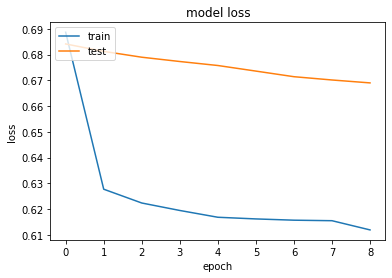

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
movie_df = moviesDf

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 48426
Movies with high ratings from user
--------------------------------
Father of the Bride Part II : Comedy
Rashomon (Rashômon) : Crime Drama Mystery
--------------------------------
Top 10 movie recommendations
--------------------------------
Léon: The Professional (a.k.a. The Professional) (Léon) : Action Crime Drama Thriller
Pulp Fiction : Comedy Crime Drama Thriller
Shawshank Redemption, The : Crime Drama
Silence of the Lambs, The : Crime Horror Thriller
Godfather, The : Crime Drama
Saving Private Ryan : Action Drama War
American Beauty : Drama Romance
Amelie (Fabuleux destin d'Amélie Poulain, Le) : Comedy Romance
Spirited Away (Sen to Chihiro no kamikakushi) : Adventure Animation Fantasy
Lord of the Rings: The Return of the King, The : Action Adventure Drama Fantasy


<h3> here is another amazing source: 

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb